In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, nbinom
from scipy.integrate import quad

### QUESTION 2 SOLUTIONS:

In [2]:
def posterior_params(
    n: int,
    sum_y: int,
    alpha: float,
    beta: float
) -> Tuple[float, float]:
    """
    Compute Gamma posterior parameters under Poisson-Gamma conjugacy.

    Args:
        n (int): Sample size in the group.
        sum_y (int): Sum of counts in the group.
        alpha (float): Prior Gamma shape for theta.
        beta (float): Prior Gamma rate for theta.

    Returns:
        Tuple[float, float]: Posterior (shape, rate) for theta.

    Raises:
        ValueError: If any input is invalid (negative counts or nonpositive
        hyperparameters).
    """
    if n < 0 or sum_y < 0:
        raise ValueError("n and sum_y must be nonnegative.")
    if alpha <= 0.0 or beta <= 0.0:
        raise ValueError("alpha and beta must be positive.")
    return alpha + sum_y, beta + n

In [3]:
def prob_theta1_gt_theta2(
    a1: float, b1: float, a2: float, b2: float
) -> float:
    """
    Compute P(theta_1 > theta_2 | data) where theta_k ~ Gamma(a_k, rate=b_k),
    independent.

    Args:
        a1 (float): Posterior shape for theta_1.
        b1 (float): Posterior rate for theta_1.
        a2 (float): Posterior shape for theta_2.
        b2 (float): Posterior rate for theta_2.

    Returns:
        float: Probability that theta_1 exceeds theta_2.

    Raises:
        ValueError: If shapes or rates are not positive.
    """
    if min(a1, b1, a2, b2) <= 0.0:
        raise ValueError("All shapes and rates must be positive.")

    def integrand(x: float) -> float:
        return gamma.cdf(x, a=a2, scale=1.0 / b2) * gamma.pdf(
            x, a=a1, scale=1.0 / b1
        )

    val, _ = quad(
        integrand, 0.0, np.inf, limit=500, epsabs=1e-10, epsrel=1e-10
    )
    return float(val)

In [4]:
def predictive_params(a_post: float, b_post: float) -> Tuple[float, float]:
    """
    Obtain Negative Binomial parameters for the posterior predictive of a
    Poisson mean with Gamma(a_post, rate=b_post) posterior on theta.

    The resulting predictive is NB(size=a_post, p=b_post/(b_post+1))
    with SciPy's parameterization.

    Args:
        a_post (float): Posterior Gamma shape.
        b_post (float): Posterior Gamma rate.

    Returns:
        Tuple[float, float]: (size, p) parameters for scipy.stats.nbinom.

    Raises:
        ValueError: If parameters are not positive.
    """
    if a_post <= 0.0 or b_post <= 0.0:
        raise ValueError("a_post and b_post must be positive.")
    size = a_post
    p = b_post / (b_post + 1.0)
    return size, p

In [5]:
def predictive_probs(
    size1: float,
    p1: float,
    size2: float,
    p2: float,
    q: float = 0.999999,
) -> Tuple[float, float, int]:
    """
    Compute predictive comparison probabilities using y_tilde notation.

    Computes:
      - P(y_tilde_2 > y_tilde_1 | data)
      - P(y_tilde_2 = y_tilde_1 | data)

    by summing Negative Binomial pmfs up to a quantile-based truncation.

    Args:
        size1 (float): NB 'size' for group 1 (posterior predictive).
        p1 (float): NB 'p' for group 1.
        size2 (float): NB 'size' for group 2.
        p2 (float): NB 'p' for group 2.
        q (float): Upper-tail quantile for truncation (default 0.999999).

    Returns:
        Tuple[float, float, int]: (P(y_tilde_2 > y_tilde_1),
        P(y_tilde_2 = y_tilde_1), kmax used).

    Raises:
        ValueError: If parameters are out of bounds.
    """
    if min(size1, size2) <= 0.0 or not (0.0 < p1 < 1.0) or not (0.0 < p2 < 1.0):
        raise ValueError("Invalid NB parameters.")
    if not (0.5 < q < 1.0):
        raise ValueError("q must be in (0.5, 1).")

    # Truncation via high quantiles for each NB
    kmax1 = int(nbinom.ppf(q, n=size1, p=p1))
    kmax2 = int(nbinom.ppf(q, n=size2, p=p2))
    kmax = max(kmax1, kmax2, 50)  # ensure a modest floor

    ks = np.arange(0, kmax + 1)
    pmf1 = nbinom.pmf(ks, n=size1, p=p1)  # group 1
    pmf2 = nbinom.pmf(ks, n=size2, p=p2)  # group 2
    cdf1 = nbinom.cdf(ks, n=size1, p=p1)

    # P(y_tilde_2 > y_tilde_1) =
    # sum_k pmf2(k) * P(y_tilde_1 < k) = sum_k pmf2(k) * cdf1(k-1)
    cdf1_shift = np.concatenate(([0.0], cdf1[:-1]))
    prob_gt = float(np.sum(pmf2 * cdf1_shift))

    # P(y_tilde_2 = y_tilde_1) = sum_k pmf2(k) * pmf1(k)
    prob_eq = float(np.sum(pmf2 * pmf1))

    return prob_gt, prob_eq, kmax




In [6]:
def plot_posterior_theta(
    a1_post: float,
    b1_post: float,
    a2_post: float,
    b2_post: float
) -> None:
    """
    Plot posterior Gamma densities for theta_1 and theta_2.

    Args:
        a1_post (float): Posterior shape for theta_1.
        b1_post (float): Posterior rate for theta_1.
        a2_post (float): Posterior shape for theta_2.
        b2_post (float): Posterior rate for theta_2.

    Returns:
        None

    Raises:
        ValueError: If parameters are nonpositive.
    """
    if min(a1_post, b1_post, a2_post, b2_post) <= 0.0:
        raise ValueError("Shapes and rates must be positive.")

    # Choose a grid informed by posterior means
    mean1 = a1_post / b1_post
    mean2 = a2_post / b2_post
    xmax = float(max(mean1, mean2) * 3.0)
    xs = np.linspace(0.0, xmax, 2000)

    pdf1 = gamma.pdf(xs, a=a1_post, scale=1.0 / b1_post)
    pdf2 = gamma.pdf(xs, a=a2_post, scale=1.0 / b2_post)

    plt.figure()
    plt.plot(xs, pdf1, linewidth=2.0, label="theta_1 | data")
    plt.plot(xs, pdf2, linewidth=2.0, label="theta_2 | data")
    plt.title("Posterior densities for theta_1 and theta_2")
    plt.xlabel("theta")
    plt.ylabel("density")
    plt.legend()
    plt.show()

In [7]:
def plot_predictive_pmfs(
    size1: float, p1: float, size2: float, p2: float, kmax: int
) -> None:
    """
    Plot posterior predictive PMFs for y_tilde_1 and y_tilde_2 up to kmax.

    Args:
        size1 (float): NB 'size' for group 1.
        p1 (float): NB 'p' for group 1.
        size2 (float): NB 'size' for group 2.
        p2 (float): NB 'p' for group 2.
        kmax (int): Maximum k to display.

    Returns:
        None

    Raises:
        ValueError: If kmax is not positive.
    """
    if kmax <= 0:
        raise ValueError("kmax must be positive.")

    ks = np.arange(0, kmax + 1)
    pmf1 = nbinom.pmf(ks, n=size1, p=p1)
    pmf2 = nbinom.pmf(ks, n=size2, p=p2)

    # Plot group 1 PMF
    plt.figure()
    plt.stem(ks, pmf1)
    plt.title("Posterior predictive PMF: y_tilde_1")
    plt.xlabel("y_tilde_1")
    plt.ylabel("probability")
    plt.show()

    # Plot group 2 PMF
    plt.figure()
    plt.stem(ks, pmf2)
    plt.title("Posterior predictive PMF: y_tilde_2")
    plt.xlabel("y_tilde_2")
    plt.ylabel("probability")
    plt.show()

Posterior and predictive probabilities (alternative prior):
P(theta_1 > theta_2 | data): 0.732240
P(y_tilde_2 > y_tilde_1 | data): 0.372800
P(y_tilde_2 = y_tilde_1 | data): 0.212037
Truncation diagnostic:
kmax used: 50
Right-tail mass group1 at kmax: 0.000e+00
Right-tail mass group2 at kmax: 0.000e+00


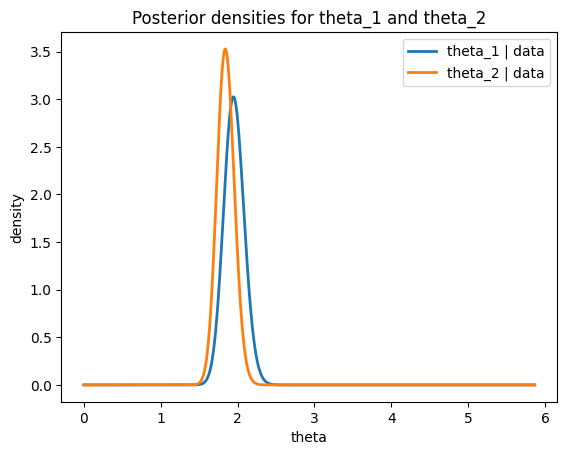

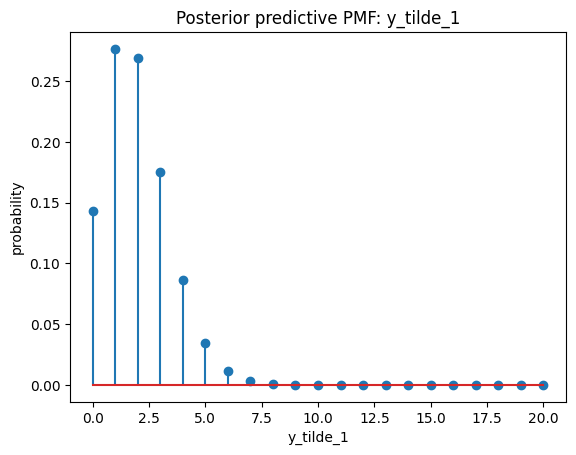

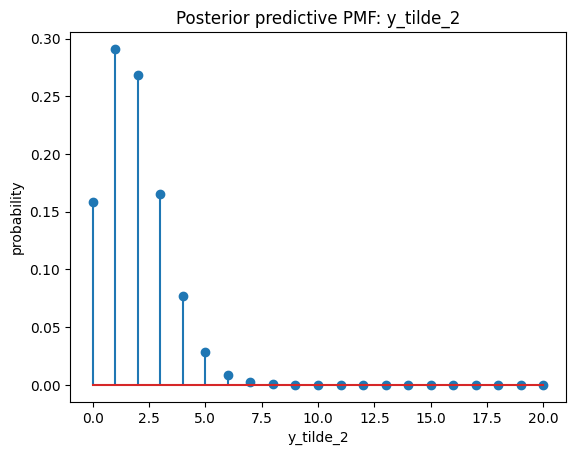

In [8]:
# Data
n1, sum_y1 = 111, 217
n2, sum_y2 = 44, 66

# Alternative priors
alpha1, beta1 = 2.0, 1.0
alpha2, beta2 = 200.0, 100.0

# Posterior parameters
a1_post, b1_post = posterior_params(n1, sum_y1, alpha1, beta1)
a2_post, b2_post = posterior_params(n2, sum_y2, alpha2, beta2)

# Question (a)
p_theta1_gt_theta2 = prob_theta1_gt_theta2(a1_post, b1_post, a2_post, b2_post)

# Predictive parameters
size1, p1 = predictive_params(a1_post, b1_post)
size2, p2 = predictive_params(a2_post, b2_post)

# Questions (b) and (c)
p_y2_gt_y1, p_y2_eq_y1, kmax = predictive_probs(size1, p1, size2, p2, q=0.999999)

rows = [
    ("P(theta_1 > theta_2 | data)", p_theta1_gt_theta2),
    ("P(y_tilde_2 > y_tilde_1 | data)", p_y2_gt_y1),
    ("P(y_tilde_2 = y_tilde_1 | data)", p_y2_eq_y1),
]
df = pd.DataFrame(rows, columns=["Quantity", "Value"])

print("Posterior and predictive probabilities (alternative prior):")
for label, val in rows:
    print(f"{label}: {val:.6f}")

# Tail diagnostics
tail1 = 1.0 - nbinom.cdf(kmax, n=size1, p=p1)
tail2 = 1.0 - nbinom.cdf(kmax, n=size2, p=p2)
print("Truncation diagnostic:")
print(f"kmax used: {kmax}")
print(f"Right-tail mass group1 at kmax: {tail1:.3e}")
print(f"Right-tail mass group2 at kmax: {tail2:.3e}")

# Plots
plot_posterior_theta(a1_post, b1_post, a2_post, b2_post)
plot_predictive_pmfs(size1, p1, size2, p2, kmax=min(kmax, 20))

# Birth Rate example: alternative prior, Page 11 answers (ASCII only)

## Mapping of questions to model quantities
- Question (a) -> parameter comparison: P(theta_1 > theta_2 | data)
  Interpretation: mean number of children for no-college women exceeds that for college women.
- Question (b) -> predictive comparison (strict inequality): P(y_tilde_2 > y_tilde_1 | data)
  Interpretation: a college woman has strictly more children than a no-college woman in a new pair.
- Question (c) -> predictive tie: P(y_tilde_2 = y_tilde_1 | data)
  Interpretation: they have exactly the same number of children in a new pair.

## Group mapping and notation
- Group 1: women without college degree, rate theta_1, predictive y_tilde_1.
- Group 2: women with college degree, rate theta_2, predictive y_tilde_2.

## Priors and posteriors (shape-rate convention)
- Priors: theta_1 ~ Gamma(2, 1), theta_2 ~ Gamma(200, 100).
- Let n_j be the sample size and S_j = sum_i y_ij the total count in group j.
  - theta_1 | data ~ Gamma(2 + S_1, 1 + n_1)
  - theta_2 | data ~ Gamma(200 + S_2, 100 + n_2)

## Posterior predictive laws
For a new individual in group j, the Poisson-Gamma mixture implies:
- y_tilde_j | data ~ NegBin(r_j, p_j)
- r_j = posterior shape for group j
- p_j = posterior rate / (posterior rate + 1)

Notes: NegBin(r, p) here is the count form (number of failures) with pmf proportional to choose(k + r - 1, k) * (1 - p)^k * p^r.

---

## Answers mapped to (i)-(iii)

- (a)  P(theta_1 > theta_2 | data) = 0.732240
- (b) P(y_tilde_2 > y_tilde_1 | data) = 0.372800
- (c)) P(y_tilde_2 = y_tilde_1 | data) = 0.212037

For completeness:
- P(y_tilde_2 < y_tilde_1 | data) = 1 - 0.372800 - 0.212037 = 0.415163

---

## Computation notes
- Predictive probabilities computed by summing the joint NB pmfs over {l > k} and {l = k} with truncation at k_max = 50.
- Right-tail mass at k_max:
  - group 1: 0.000e+00
  - group 2: 0.000e+00
- The remainder beyond k_max is negligible, so the truncation is adequate.

### Question 3.d.

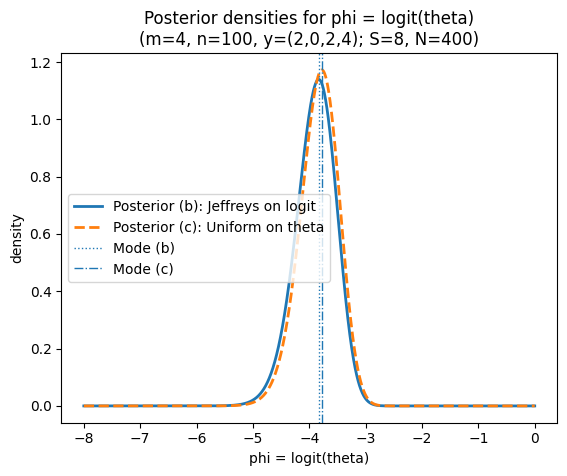

In [9]:
from scipy.special import beta as beta_fn

# Data and sufficient stats
m, n = 4, 100
y = np.array([2, 0, 2, 4])
S = int(y.sum())
N = m * n

# Posterior densities on phi (normalized)
def posterior_phi_b(phi: np.ndarray, S: int, N: int) -> np.ndarray:
    """Jeffreys-on-logit posterior density for phi, normalized."""
    c = 1.0 / beta_fn(S + 0.5, N - S + 0.5)
    num = np.exp(phi * (S + 0.5))
    den = (1.0 + np.exp(phi)) ** (N + 1)
    return c * num / den


def posterior_phi_c(phi: np.ndarray, S: int, N: int) -> np.ndarray:
    """Uniform-on-theta posterior density for phi, normalized."""
    c = 1.0 / beta_fn(S + 1.0, N - S + 1.0)
    num = np.exp(phi * (S + 1.0))
    den = (1.0 + np.exp(phi)) ** (N + 2)
    return c * num / den


# Grid for plotting (wide enough around the posterior mass)
phi_grid = np.linspace(-8.0, 0.0, 2500)

pb = posterior_phi_b(phi_grid, S, N)
pc = posterior_phi_c(phi_grid, S, N)

# Modes on the phi-scale
# For b: solve (S+1/2) - (N+1) * logistic(phi) = 0  -> logistic(phi) = (S+1/2)/(N+1)
# For c: solve (S+1)   - (N+2) * logistic(phi) = 0  -> logistic(phi) = (S+1)/(N+2)
logit = lambda p: np.log(p / (1.0 - p))
theta_mode_b = (S + 0.5) / (N + 1.0)
theta_mode_c = (S + 1.0) / (N + 2.0)
phi_mode_b = logit(theta_mode_b)
phi_mode_c = logit(theta_mode_c)

# Plot
plt.figure()
plt.plot(phi_grid, pb, linewidth=2, label="Posterior (b): Jeffreys on logit")
plt.plot(phi_grid, pc, linewidth=2, linestyle="--", label="Posterior (c): Uniform on theta")
plt.axvline(phi_mode_b, linestyle=":", linewidth=1, label="Mode (b)")
plt.axvline(phi_mode_c, linestyle="-.", linewidth=1, label="Mode (c)")
plt.title("Posterior densities for phi = logit(theta)\n(m=4, n=100, y=(2,0,2,4); S=8, N=400)")
plt.xlabel("phi = logit(theta)")
plt.ylabel("density")
plt.legend()
plt.show()


In [10]:
# Report key stats
print("Sufficient stats: S =", S, " N =", N)
print("Mode (b): phi =", f"{phi_mode_b:.4f}", "  theta =", f"{theta_mode_b:.6f}")
print("Mode (c): phi =", f"{phi_mode_c:.4f}", "  theta =", f"{theta_mode_c:.6f}")

Sufficient stats: S = 8  N = 400
Mode (b): phi = -3.8325   theta = 0.021197
Mode (c): phi = -3.7766   theta = 0.022388


- With phi = logit(theta) and m=4, n=100, y=(2,0,2,4) we have S=8, N=400, so both posteriors concentrate near phi ~ -3.8.

- Jeffreys-on-logit (part b) yields p_b(phi|y) ∝ exp((S+1/2)phi) / (1+exp(phi))^(N+1).

- Uniform-on-theta (part c) yields p_c(phi|y) ∝ exp((S+1)phi) / (1+exp(phi))^(N+2).

- Modes: phi_b = logit((S+1/2)/(N+1)) ≈ -3.832, phi_c = logit((S+1)/(N+2)) ≈ -3.777 => Uniform-on-theta is slightly to the right.

- Uniform-on-theta is marginally more concentrated with lighter tails. Differences are small because N is large and S/N is low.

### Conclusions based on comparison:

- Jeffreys (on phi = logit(theta)) is invariant to reparameterization and corresponds to Beta(1/2,1/2) on theta while uniform on theta is not invariant and induces a logistic prior on phi.

- Jeffreys tolerates extreme probabilities a bit more and penalizes them less. Uniform pulls estimates slightly toward the center.

In [11]:
def load_and_prepare_df(
    path='/content/drive/MyDrive/Colab Notebooks/treatment_data.csv'
  ):
    df = pd.read_csv(path)
    # Drop obvious index-like columns if present
    for col in ["Unnamed: 0", "index", "#", "Id", "ID"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    # If dosage/response exist, rename to x/y
    if {"dosage", "response"}.issubset(df.columns):
        df = df.rename(columns={"dosage": "x", "response": "y"})
    # If already x/y, fine; else try to infer two numeric columns
    if not {"x", "y"}.issubset(df.columns):
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if len(num_cols) < 2:
            raise ValueError("Could not find two numeric columns for x and y.")
        # Heuristic: first numeric as x, second as y
        df = df.rename(columns={num_cols[0]: "x", num_cols[1]: "y"})
    # Coerce to float and ensure no NaNs
    df = df[["x", "y"]].astype(float).dropna()
    return df

In [12]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the CSV file
try:
    df_treatment = load_and_prepare_df('/content/drive/MyDrive/Colab Notebooks/treatment_data.csv')
    print("DataFrame loaded and prepared (columns: x, y). Head:")
    print(df_treatment.head())
except FileNotFoundError:
    print("Error: treatment.csv not found in 'Colab Notebooks' folder on Google Drive.")
    print("Please make sure the file exists and the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
DataFrame loaded and prepared (columns: x, y). Head:
          x         y
0  0.620757  0.998132
1  0.035641 -2.069539
2  0.773154 -0.453353
3  1.272489 -1.167500
4  0.370975 -0.659670


In [13]:
from scipy.special import gammaln
from math import pi, sqrt

def sufficient_stats(df, x_col="x", y_col="y"):
    x = df[x_col].to_numpy(dtype=float).ravel()
    y = df[y_col].to_numpy(dtype=float).ravel()
    n = x.shape[0]
    s_xx = float(np.dot(x, x))
    s_xy = float(np.dot(x, y))
    s_yy = float(np.dot(y, y))
    return n, s_xx, s_xy, s_yy

In [14]:
def log_m0(n, s_yy):
    # m0 = Gamma(n/2) / pi^{n/2} * s_yy^{-n/2}
    return gammaln(n/2.0) - (n/2.0)*np.log(pi) - (n/2.0)*np.log(s_yy)

def log_m1(n, s_xx, s_xy, s_yy):
    # m1 = Gamma((n-1)/2) / pi^{n/2} * s_xx^{-1/2} * error^{-(n-1)/2}
    error = s_yy - (s_xy**2)/s_xx
    return (
        gammaln((n-1)/2.0)
        - (n/2.0)*np.log(pi)
        - 0.5*np.log(s_xx)
        - ((n-1)/2.0)*np.log(error)
    )

In [15]:
# ===== For (a.ii) =====
def posterior_prob_delta1(df, x_col="x", y_col="y"):
    n, s_xx, s_xy, s_yy = sufficient_stats(df, x_col, y_col)
    lm0 = log_m0(n, s_yy)
    lm1 = log_m1(n, s_xx, s_xy, s_yy)
    log_bf10 = lm1 - lm0
    bf10 = float(np.exp(log_bf10))
    w = bf10 / (1.0 + bf10)  # prior odds 1:1
    return w

In [16]:
# ---------- Collapsed "Gibbs" sampler (delta, tau^2, beta, y*_A, y*_B) ----------
def gibbs_sampler_treatment(
    df,
    xA=-2.0,
    xB=2.0,
    x_col="x",
    y_col="y",
    n_iter=100000,
    burn=10000,
    thin=1,
    seed=1234
):
    # Summaries
    def summarize(arr):
        return {
            "mean": float(np.mean(arr)),
            "sd": float(np.std(arr, ddof=1)),
            "q2.5": float(np.quantile(arr, 0.025)),
            "q50": float(np.quantile(arr, 0.5)),
            "q97.5": float(np.quantile(arr, 0.975)),
        }

    rng = np.random.default_rng(seed)
    n, s_xx, s_xy, s_yy = sufficient_stats(df, x_col, y_col)
    beta_hat = s_xy / s_xx
    sse1 = s_yy - (s_xy**2)/s_xx

    # Posterior model probability
    w = posterior_prob_delta1(df, x_col, y_col)

    keep = max(0, (n_iter - burn) // thin)
    delta_s = np.empty(keep, dtype=np.int8)
    tau2_s = np.empty(keep, dtype=float)
    beta_s = np.empty(keep, dtype=float)
    yA_s = np.empty(keep, dtype=float)
    yB_s = np.empty(keep, dtype=float)

    t = 0
    for it in range(n_iter):
        # Sample delta ~ Bernoulli(w) (collapsed step; independent of past)
        delta = 1 if rng.random() < w else 0

        if delta == 0:
            # tau^2 | y, M0 ~ Gamma(n/2, rate=S_yy/2)
            tau2 = rng.gamma(shape=n/2.0, scale=2.0/s_yy)
            beta = 0.0
            std = 1.0 / np.sqrt(tau2)
            yA = rng.normal(loc=0.0, scale=std)
            yB = rng.normal(loc=0.0, scale=std)
        else:
            # tau^2 | y, M1 ~ Gamma((n-1)/2, rate=SSE1/2)
            tau2 = rng.gamma(shape=(n-1)/2.0, scale=2.0/sse1)
            # beta | tau^2, y, M1 ~ Normal(beta_hat, var = 1/(tau^2 S_xx))
            beta = rng.normal(loc=beta_hat, scale=1.0/np.sqrt(tau2 * s_xx))
            std = 1.0 / np.sqrt(tau2)
            yA = rng.normal(loc=beta * xA, scale=std)
            yB = rng.normal(loc=beta * xB, scale=std)

        if it >= burn and ((it - burn) % thin == 0):
            delta_s[t] = delta
            tau2_s[t] = tau2
            beta_s[t] = beta
            yA_s[t] = yA
            yB_s[t] = yB
            t += 1

    out = {
        "kept": keep,
        "w_theoretical": float(w),
        "delta_mean": float(np.mean(delta_s)),
        "beta_summary": summarize(beta_s),
        "tau2_summary": summarize(tau2_s),
        "yA_summary": summarize(yA_s),
        "yB_summary": summarize(yB_s),
        "Pr_yB_gt_yA": float(np.mean(yB_s > yA_s)),
        "mean_A_analytic": float(w * xA * beta_hat),
        "mean_B_analytic": float(w * xB * beta_hat),
    }
    return out

In [17]:
res = gibbs_sampler_treatment(
    df_treatment, xA=-2.0, xB=2.0,
    x_col="x", y_col="y",
    n_iter=120000, burn=20000, thin=1, seed=20250930
)

print("Collapsed Gibbs results (i.i.d. in this model):")
print(f"  kept draws = {res['kept']}")
print(f"  w = P(delta=1 | y): theoretical = {res['w_theoretical']:.6f},"
      f"chain mean(delta) = {res['delta_mean']:.6f}")

print("\nPosterior for beta (under mixture):")
for k, v in res["beta_summary"].items():
    print(f"  {k}: {v:.6f}")

print("\nPosterior for tau^2 (under mixture):")
for k, v in res["tau2_summary"].items():
    print(f"  {k}: {v:.6f}")

print("\nPosterior predictive for Patient A (x* = -2):")
for k, v in res["yA_summary"].items():
    print(f"  {k}: {v:.6f}")
print(f"  mean (analytic) = {res['mean_A_analytic']:.6f}")

print("\nPosterior predictive for Patient B (x* = 2):")
for k, v in res["yB_summary"].items():
    print(f"  {k}: {v:.6f}")
print(f"  mean (analytic) = {res['mean_B_analytic']:.6f}")

print("\nP(y*_B > y*_A | y) from Gibbs draws:")
print(f"  {res['Pr_yB_gt_yA']:.6f}")

Collapsed Gibbs results (i.i.d. in this model):
  kept draws = 100000
  w = P(delta=1 | y): theoretical = 0.999975,chain mean(delta) = 0.999970

Posterior for beta (under mixture):
  mean: 0.172147
  sd: 0.032663
  q2.5: 0.107727
  q50: 0.172268
  q97.5: 0.235918

Posterior for tau^2 (under mixture):
  mean: 0.944898
  sd: 0.042175
  q2.5: 0.864748
  q50: 0.944271
  q97.5: 1.029602

Posterior predictive for Patient A (x* = -2):
  mean: -0.344375
  sd: 1.034702
  q2.5: -2.357612
  q50: -0.343587
  q97.5: 1.683749
  mean (analytic) = -0.344455

Posterior predictive for Patient B (x* = 2):
  mean: 0.342991
  sd: 1.030933
  q2.5: -1.671287
  q50: 0.343909
  q97.5: 2.378929
  mean (analytic) = 0.344455

P(y*_B > y*_A | y) from Gibbs draws:
  0.680660


### Summary of Answers for question 4.
- (a)(ii) Posterior for delta=1: P(delta=1 | data) = 0.999975. With equal prior odds, this indicates a compelling evidence that **dosage affects response**.

- (a)(iii) Interpretation: Posterior for beta has mean 0.172 with 95% credible interval (0.108, 0.236), entirely positive, so presumably, the effect is credibly beneficial.

- (b)(ii) Predictive: \
A (x* =-2): mean -0.344, 95% PI [-2.358, 1.684]. \
B (x* = 2): mean 0.343, 95% PI [-1.671, 2.379].\
Analytic means match simulation upto 2 decimal places.

- (b)(iii) Superiority: \
P(y_B > y_A | data) = 0.681. \
Higher dose is more likely better, but not near 0.8 to 0.9 thresholds.

- (b)(iv) Conclusion: \
Strong evidence the dose matters, with average gain about 0.68 for a 4 unit increase, but wide individual variability.

### Disclosure: Sought the help of Gemini AI for Question 4.b. for explaining the derivations of some calculus problems I got as a part of t-distributions. I had explicitly derived the calculus for 4.a. but for 4.b. I used standard results wherever I could.

### Similarly, I saw a couple of code examples in github for the gibbs sampler to implement properly and expand my understanding of the same. I didn't understand the concept of burn, so I went through a few youtube videos as well to understand the same.